In [493]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [494]:
X = pd.read_csv("data/train.csv")
X_test = pd.read_csv("data/test.csv")





 mu = 180921.20 and sigma = 79415.29



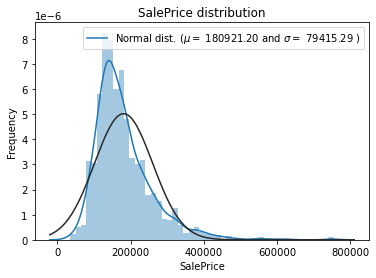

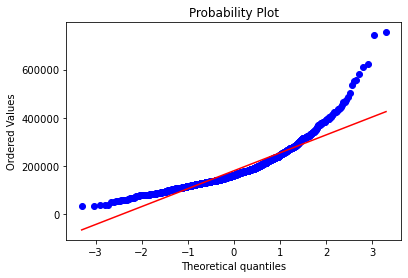


 mu = 12.02 and sigma = 0.40



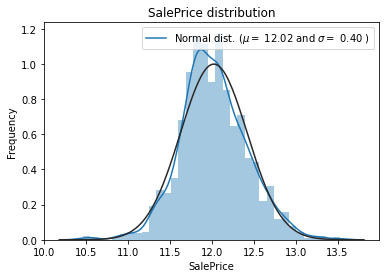

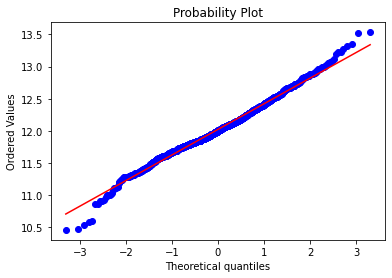

In [495]:
#correcting right Skew of data

sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()


#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
X["SalePrice"] = np.log1p(X["SalePrice"])

#Check the new distribution 
sns.distplot(X['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(X['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(X['SalePrice'], plot=plt)
plt.show()

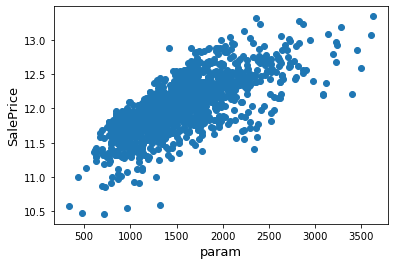

In [496]:
#drop outlier
X = X.drop(X[(X['GrLivArea']>4000) & (X['SalePrice']<300000)].index)
fig, ax = plt.subplots()
ax.scatter(x = X['GrLivArea'], y = X['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('param', fontsize=13)
plt.show()

<AxesSubplot:>

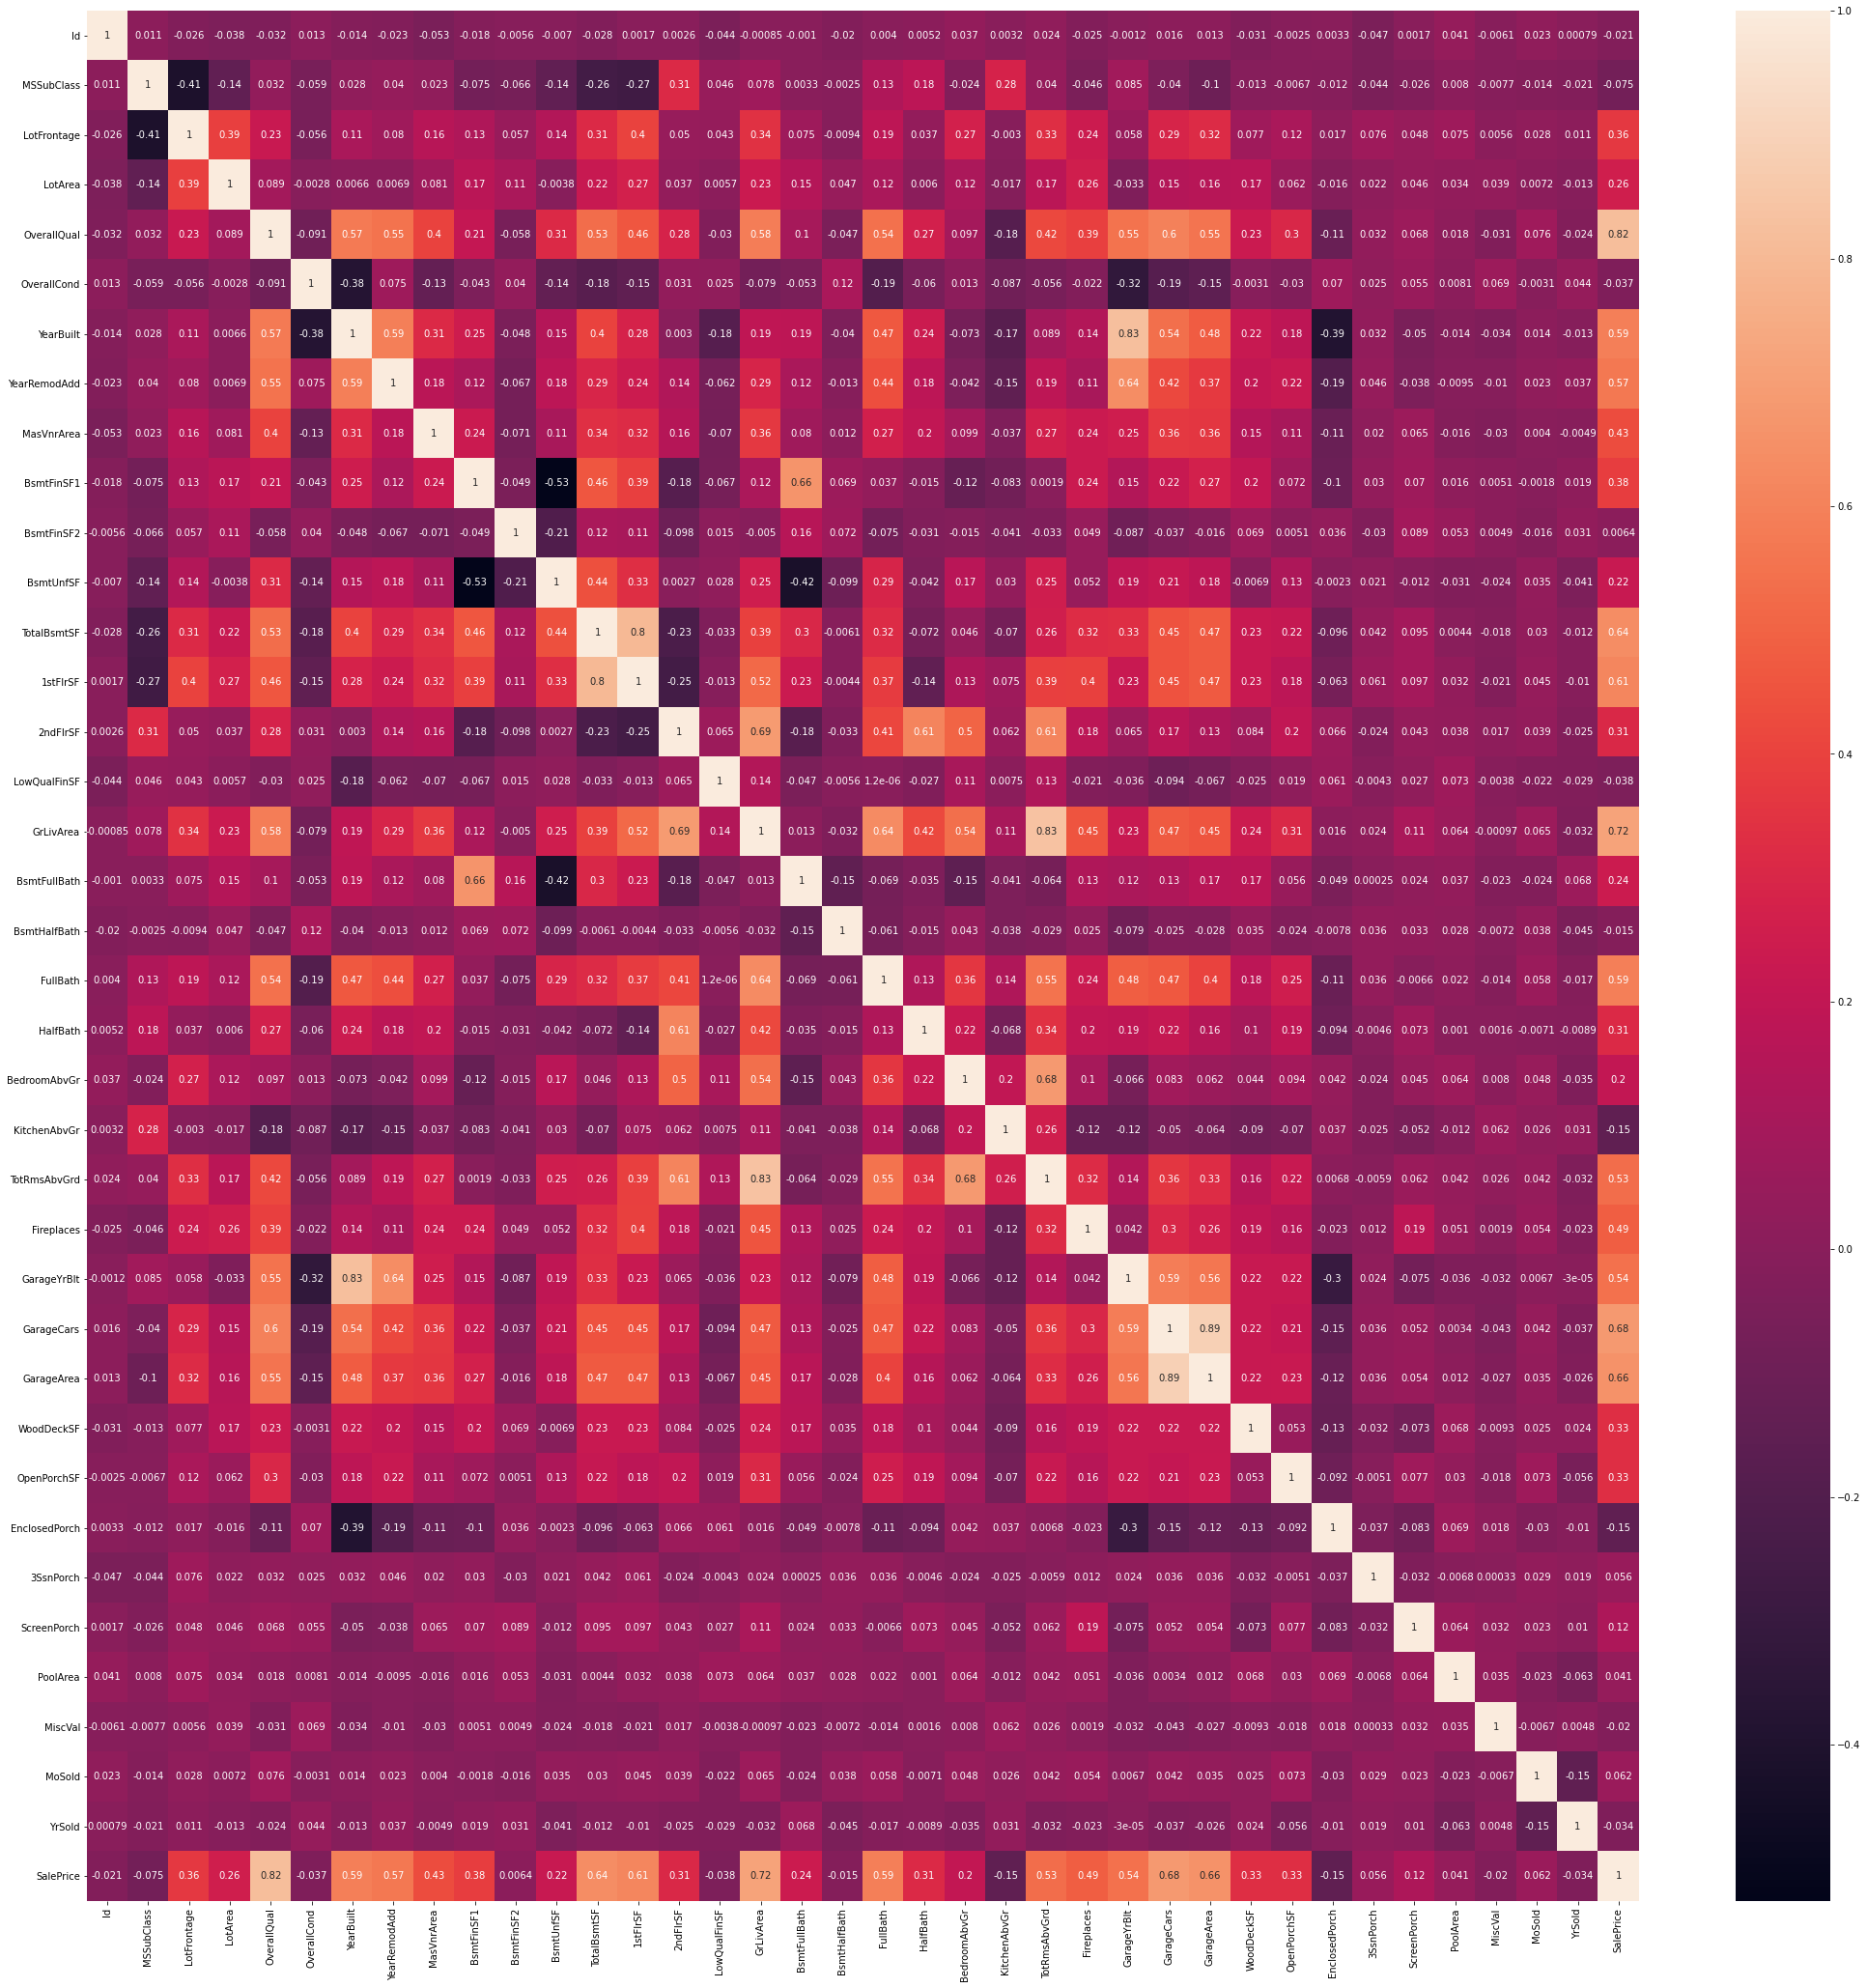

In [497]:
fig, ax = plt.subplots(figsize=(36, 36))
df_corr = X.corr()

sns.heatmap(df_corr,annot=True)

In [498]:
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice              
X.drop(['SalePrice'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)


In [499]:

def prep_missing(dfin):

    dfin.drop(['GarageYrBlt'], axis=1, inplace=True)
    dfin.drop(['Utilities'], axis=1, inplace=True)
    
    dfin.Electrical = dfin.Electrical.fillna('SBrkr')
    dfin.BsmtFinSF1 = dfin.BsmtFinSF1.fillna(0)
    dfin.BsmtFinSF2 = dfin.BsmtFinSF2.fillna(0)
    dfin.GarageCars = dfin.GarageCars.fillna(0)
    dfin.GarageArea = dfin.GarageArea.fillna(0)
    dfin["PoolQC"] = dfin["PoolQC"].fillna("NA")
    dfin.BsmtQual[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtQual[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtCond[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtCond[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtCond = dfin.BsmtCond.fillna('TA')
    dfin.BsmtExposure[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtExposure[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtFinType1[(dfin.BsmtFinSF1 == 0)] = dfin.BsmtFinType1[(dfin.BsmtFinSF1 == 0)].fillna('NA')
    dfin.BsmtFinType2[(dfin.BsmtFinSF2 == 0)] = dfin.BsmtFinType2[(dfin.BsmtFinSF2 == 0)].fillna('NA')
    dfin.BsmtFinType2 = dfin.BsmtFinType2.fillna('Unf')
    dfin["MiscFeature"] = dfin["MiscFeature"].fillna("NA")
    dfin["Alley"] = dfin["Alley"].fillna("NA")
    dfin["Fence"] = dfin["Fence"].fillna("NA")
    dfin["FireplaceQu"] = dfin["FireplaceQu"].fillna("NA")
    dfin['MSSubClass'] = dfin['MSSubClass'].fillna("NA")
    for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
        dfin[col] = dfin[col].fillna('NA')
    
    
    
    #Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
    dfin["LotFrontage"] = dfin.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
    
    dfin.MasVnrArea = dfin.MasVnrArea.fillna(0)
    dfin.MasVnrType = dfin.MasVnrType.fillna('None')
    dfin.KitchenQual = dfin.KitchenQual.fillna('TA')
    dfin.Functional = dfin.Functional.fillna('Typ')
    dfin.BsmtUnfSF = dfin.BsmtUnfSF.fillna(0)
    dfin.TotalBsmtSF = dfin.TotalBsmtSF.fillna(0)
    dfin.BsmtFullBath = dfin.BsmtFullBath.fillna(0)
    dfin.BsmtHalfBath = dfin.BsmtHalfBath.fillna(0)
    
    #feature engineering for the Neighborhood
    dfin.loc[(dfin.Neighborhood == 'NridgHt') | (dfin.Neighborhood == 'NoRidge'), ['GoodNBH']] = 1
    dfin.GoodNBH = dfin.GoodNBH.fillna(0)
    dfin.drop(['Neighborhood'], axis=1, inplace=True)
    
    #Drop Categoricals that cannot be one hotted, and also not ordinally encoded
    dfin['Exterior1st'] = dfin['Exterior1st'].fillna(dfin['Exterior1st'].mode()[0])
    dfin['Exterior2nd'] = dfin['Exterior2nd'].fillna(dfin['Exterior2nd'].mode()[0])
    
    dfin['MSZoning'] = dfin['MSZoning'].fillna(dfin['MSZoning'].mode()[0])
    dfin['SaleType'] = dfin['SaleType'].fillna(dfin['SaleType'].mode()[0])
    
    #Convert data thats really categorical
    dfin['MSSubClass'] = dfin['MSSubClass'].apply(str) 
    dfin['OverallQual'] = dfin['OverallQual'].astype(str)  
    dfin['OverallCond'] = dfin['OverallCond'].astype(str)    
    dfin['YrSold'] = dfin['YrSold'].astype(str)
    dfin['MoSold'] = dfin['MoSold'].astype(str)
    dfin['TotalSF'] = dfin['TotalBsmtSF'] + dfin['1stFlrSF'] + dfin['2ndFlrSF']
    
    return dfin

X_train = prep_missing(X_train)
X_valid = prep_missing(X_valid)
X_test = prep_missing(X_test)



In [500]:
def prep_encoding(dfin,dfin_valid,dfin_test):
    
    # Get list of categorical variables
    s = (dfin.dtypes == 'object')
    object_cols = list(s[s].index)
    OrdinalCols = ['YrSold', 'MoSold','OverallCond','OverallQual','MSSubClass','Exterior1st','Exterior2nd','GarageFinish','GarageType','Alley','FireplaceQu','Fence','MiscFeature','PoolQC','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','CentralAir','KitchenQual','Functional']
    NominalCols = [item for item in object_cols if item not in OrdinalCols]
    

    from sklearn.preprocessing import OrdinalEncoder
    ExterQual_enc = OrdinalEncoder(categories=[['Po','Fa','TA','Gd','Ex']])
    dfin[['ExterQual']] = ExterQual_enc.fit_transform(dfin[['ExterQual']])
  

    dfin[['ExterCond']] = ExterQual_enc.fit_transform(dfin[['ExterCond']])
    dfin[['HeatingQC']] = ExterQual_enc.fit_transform(dfin[['HeatingQC']])
    dfin[['KitchenQual']] = ExterQual_enc.fit_transform(dfin[['KitchenQual']])
    
    dfin_valid[['ExterQual']] = ExterQual_enc.transform(dfin_valid[['ExterQual']])    
    dfin_valid[['ExterCond']] = ExterQual_enc.transform(dfin_valid[['ExterCond']])
    dfin_valid[['HeatingQC']] = ExterQual_enc.transform(dfin_valid[['HeatingQC']])
    dfin_valid[['KitchenQual']] = ExterQual_enc.transform(dfin_valid[['KitchenQual']])

    dfin_test[['ExterQual']] = ExterQual_enc.transform(dfin_test[['ExterQual']])
    dfin_test[['ExterCond']] = ExterQual_enc.transform(dfin_test[['ExterCond']])
    dfin_test[['HeatingQC']] = ExterQual_enc.transform(dfin_test[['HeatingQC']])
    dfin_test[['KitchenQual']] = ExterQual_enc.transform(dfin_test[['KitchenQual']])

    BsmtQual_enc = OrdinalEncoder(categories=[['NA','Po','Fa','TA','Gd','Ex']])
    dfin[['BsmtQual']] = BsmtQual_enc.fit_transform(dfin[['BsmtQual']])
    dfin[['BsmtCond']] = BsmtQual_enc.fit_transform(dfin[['BsmtCond']])
    
    dfin_valid[['BsmtQual']] = BsmtQual_enc.transform(dfin_valid[['BsmtQual']])
    dfin_valid[['BsmtCond']] = BsmtQual_enc.transform(dfin_valid[['BsmtCond']])    

    dfin_test[['BsmtQual']] = BsmtQual_enc.transform(dfin_test[['BsmtQual']])
    dfin_test[['BsmtCond']] = BsmtQual_enc.transform(dfin_test[['BsmtCond']]) 
    
    
    
    PoolQC_enc = OrdinalEncoder(categories=[['NA','Fa','TA','Gd','Ex']])
    dfin[['PoolQC']] = PoolQC_enc.fit_transform(dfin[['PoolQC']])
    dfin_valid[['PoolQC']] = PoolQC_enc.transform(dfin_valid[['PoolQC']])
    dfin_test[['PoolQC']] = PoolQC_enc.transform(dfin_test[['PoolQC']])
    
    MiscFeature_enc = OrdinalEncoder(categories=[['NA','Othr','Shed','Gar2','Elev','TenC']])
    dfin[['MiscFeature']] = MiscFeature_enc.fit_transform(dfin[['MiscFeature']])
    dfin_valid[['MiscFeature']] = MiscFeature_enc.transform(dfin_valid[['MiscFeature']]) 
    dfin_test[['MiscFeature']] = MiscFeature_enc.transform(dfin_test[['MiscFeature']]) 

    Fence_enc = OrdinalEncoder(categories=[['NA','MnWw','GdWo','MnPrv','GdPrv']])
    dfin[['Fence']] = Fence_enc.fit_transform(dfin[['Fence']])
    dfin_valid[['Fence']] = Fence_enc.transform(dfin_valid[['Fence']])   
    dfin_test[['Fence']] = Fence_enc.transform(dfin_test[['Fence']]) 
    
    FireplaceQu_enc = OrdinalEncoder(categories=[['NA','Po','Fa','TA','Gd','Ex']])
    dfin[['FireplaceQu']] = FireplaceQu_enc.fit_transform(dfin[['FireplaceQu']])
    dfin_valid[['FireplaceQu']] = FireplaceQu_enc.transform(dfin_valid[['FireplaceQu']])     
    dfin_test[['FireplaceQu']] = FireplaceQu_enc.transform(dfin_test[['FireplaceQu']])   
    
    Alley_enc = OrdinalEncoder(categories=[['NA','Grvl','Pave']])
    dfin[['Alley']] = Alley_enc.fit_transform(dfin[['Alley']])
    dfin_valid[['Alley']] = Alley_enc.transform(dfin_valid[['Alley']]) 
    dfin_test[['Alley']] = Alley_enc.transform(dfin_test[['Alley']])   
        
    BsmtExposure_enc = OrdinalEncoder(categories=[['NA','No','Mn','Av','Gd']])
    dfin[['BsmtExposure']] = BsmtExposure_enc.fit_transform(dfin[['BsmtExposure']])
    dfin_valid[['BsmtExposure']] = BsmtExposure_enc.transform(dfin_valid[['BsmtExposure']])
    dfin_test[['BsmtExposure']] = BsmtExposure_enc.transform(dfin_test[['BsmtExposure']])

    BsmtFinType1_enc = OrdinalEncoder(categories=[['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ']])
    dfin[['BsmtFinType1']] = BsmtFinType1_enc.fit_transform(dfin[['BsmtFinType1']])
    dfin[['BsmtFinType2']] = BsmtFinType1_enc.fit_transform(dfin[['BsmtFinType2']])
    
    dfin_valid[['BsmtFinType1']] = BsmtFinType1_enc.transform(dfin_valid[['BsmtFinType1']])
    dfin_valid[['BsmtFinType2']] = BsmtFinType1_enc.transform(dfin_valid[['BsmtFinType2']])

    dfin_test[['BsmtFinType1']] = BsmtFinType1_enc.transform(dfin_test[['BsmtFinType1']])
    dfin_test[['BsmtFinType2']] = BsmtFinType1_enc.transform(dfin_test[['BsmtFinType2']])

    CentralAir_enc = OrdinalEncoder(categories=[['N','Y']])
    dfin[['CentralAir']] = CentralAir_enc.fit_transform(dfin[['CentralAir']])
    dfin_valid[['CentralAir']] = CentralAir_enc.transform(dfin_valid[['CentralAir']])  
    dfin_test[['CentralAir']] = CentralAir_enc.transform(dfin_test[['CentralAir']])   

    Functional_enc = OrdinalEncoder(categories=[['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ']])
    dfin[['Functional']] = Functional_enc.fit_transform(dfin[['Functional']])
    dfin_valid[['Functional']] = Functional_enc.transform(dfin_valid[['Functional']])
    dfin_test[['Functional']] = Functional_enc.transform(dfin_test[['Functional']])

    GarageQual_enc = OrdinalEncoder(categories=[['NA','Po','Fa','TA','Gd','Ex']])
    dfin[['GarageQual']] = GarageQual_enc.fit_transform(dfin[['GarageQual']])
    dfin_valid[['GarageQual']] = GarageQual_enc.transform(dfin_valid[['GarageQual']]) 
    dfin_test[['GarageQual']] = GarageQual_enc.transform(dfin_test[['GarageQual']])    

    GarageCond_enc = OrdinalEncoder(categories=[['NA','Po','Fa','TA','Gd','Ex']])
    dfin[['GarageCond']] = GarageCond_enc.fit_transform(dfin[['GarageCond']])
    dfin_valid[['GarageCond']] = GarageCond_enc.transform(dfin_valid[['GarageCond']])  
    dfin_test[['GarageCond']] = GarageCond_enc.transform(dfin_test[['GarageCond']]) 
    
    MSSubClass_enc = OrdinalEncoder(categories=[['20','30','40','45','50','60','70','75','80','85','90','120','150','160','180','190']])
    dfin[['MSSubClass']] = MSSubClass_enc.fit_transform(dfin[['MSSubClass']])
    dfin_valid[['MSSubClass']] = MSSubClass_enc.transform(dfin_valid[['MSSubClass']]) 
    dfin_test[['MSSubClass']] = MSSubClass_enc.transform(dfin_test[['MSSubClass']])  
    
    
    from sklearn.preprocessing import LabelEncoder
    cols = ('YrSold', 'MoSold','OverallCond','OverallQual','GarageType', 'GarageFinish','Exterior1st','Exterior2nd')
    # process columns, apply LabelEncoder to categorical features
    for c in cols:
        lbl = LabelEncoder() 
        lbl.fit(list(dfin[c].values)) 
        dfin[c] = lbl.transform(list(dfin[c].values))
        dfin_valid[c] = lbl.transform(list(dfin_valid[c].values))
        dfin_test[c] = lbl.transform(list(dfin_test[c].values))
    
    
    from sklearn.preprocessing import OneHotEncoder
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    OH_X_train_cols = pd.DataFrame(OH_encoder.fit_transform(dfin[NominalCols]))

    OH_X_valid_cols = pd.DataFrame(OH_encoder.transform(dfin_valid[NominalCols]))
    OH_X_test_cols = pd.DataFrame(OH_encoder.transform(dfin_test[NominalCols]))

    OH_X_train_cols.index = dfin.index
    OH_X_valid_cols.index = dfin_valid.index
    OH_X_test_cols.index = dfin_test.index
    num_OH_X_train = dfin.drop(NominalCols, axis=1)
    num_OH_X_valid = dfin_valid.drop(NominalCols, axis=1)  
    num_OH_X_test = dfin_test.drop(NominalCols, axis=1)
    OH_X_train = pd.concat([num_OH_X_train,OH_X_train_cols], axis=1)
    OH_X_valid = pd.concat([num_OH_X_valid,OH_X_valid_cols], axis=1)    
    OH_X_test = pd.concat([num_OH_X_test,OH_X_test_cols], axis=1)   

    return OH_X_train, OH_X_valid, OH_X_test

X_train, X_valid, X_test = prep_encoding(X_train,X_valid,X_test)




Skew in numerical features: 

There are 33 skewed numerical features to Box Cox transform


In [515]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

# function for comparing different approaches

#Random Forest
model1 = RandomForestRegressor(n_estimators=800, random_state=0)
model1.fit(X_train, y_train)
preds1 = model1.predict(X_valid)


print("Randomforest: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(preds1))))





Randomforest: 16172.999798979823


In [555]:
#XGBOOST

from xgboost import XGBRegressor
model2 = XGBRegressor(n_estimators=800, learning_rate=0.03)
model2.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)
preds2 = model2.predict(X_valid)

print("XGBOOST: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(preds2))))

XGBOOST: 15504.466944028254


In [581]:
#Pimped XGBOOST

model3 = XGBRegressor( 
                             learning_rate=0.05, max_depth=3, 
                              n_estimators=200)

model3.fit(X_train, y_train, 
             early_stopping_rounds=5, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False)
preds3 = model3.predict(X_valid)

print("Pimped XGBOOST: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(preds3))))

Pimped XGBOOST: 14794.236609053942


In [576]:
#Lasso met Scaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
model4 = make_pipeline(RobustScaler(), Lasso(alpha =0.0003, random_state=0))

model4.fit(X_train, y_train)
preds4 = model4.predict(X_valid)

print("Lasso: " + str(mean_absolute_error(np.expm1(y_valid), np.expm1(preds4))))

Lasso: 14407.362765007387


In [582]:
preds = model3.predict(X_test)

In [583]:
df = pd.DataFrame(columns=['Id','SalePrice'])
df['Id'] = X_test.Id
df['SalePrice'] = np.expm1(preds)
df[['Id','SalePrice']].to_csv('submission1.csv', index=False)